In [24]:
!pip install kaggle pandas numpy scikit-learn matplotlib seaborn joblib lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import lightgbm as lgb

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('✅ Packages imported')

✅ Packages imported


In [2]:
from google.colab import files

print('kaggle.json:')
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print('Configured')

📁 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully!


In [36]:
!kaggle datasets download -d mubashirrahim/wind-power-generation-data-forecasting

with zipfile.ZipFile('wind-power-generation-data-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('wind_data')

for file in os.listdir('wind_data'):
    print(f'  - {file}')


Dataset URL: https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting
License(s): CC0-1.0
wind-power-generation-data-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
  - Location3.csv
  - Location4.csv
  - readme.txt
  - Location1.csv
  - Location2.csv


In [38]:
datasets = {}
location_files = [f for f in os.listdir('wind_data') if f.endswith('.csv')]

print('Loading wind power data from multiple locations:')
for file in location_files:
    location_name = file.replace('.csv', '')
    df = pd.read_csv(f'wind_data/{file}')
    datasets[location_name] = df
    print(f'  📍 {location_name}: {len(df)} records')

combined_df = pd.concat(datasets.values(), ignore_index=True)
print(f'Combined dataset: {len(combined_df)} total records')

print('Dataset Info:')
print(combined_df.info())

Loading wind power data from multiple locations:
  📍 Location3: 43800 records
  📍 Location4: 43800 records
  📍 Location1: 43800 records
  📍 Location2: 43800 records
Combined dataset: 175200 total records
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175200 entries, 0 to 175199
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Time                 175200 non-null  object 
 1   temperature_2m       175200 non-null  float64
 2   relativehumidity_2m  175200 non-null  int64  
 3   dewpoint_2m          175200 non-null  float64
 4   windspeed_10m        175200 non-null  float64
 5   windspeed_100m       175200 non-null  float64
 6   winddirection_10m    175200 non-null  int64  
 7   winddirection_100m   175200 non-null  int64  
 8   windgusts_10m        175200 non-null  float64
 9   Power                175200 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 13.4+

In [39]:
def add_features(df):
    df = df.copy()

    df['hour'] = df['Time'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear'] = df['Time'].dt.dayofyear
    df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    lag_cols = ['windspeed_10m', 'windspeed_100m', 'windgusts_10m', 'Power']
    for col in lag_cols:
        for lag in [1, 3, 6]:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
        df[f'{col}_roll3_mean'] = df[col].rolling(window=3).mean()
        df[f'{col}_roll3_std'] = df[col].rolling(window=3).std()
        df[f'{col}_roll6_mean'] = df[col].rolling(window=6).mean()
        df[f'{col}_roll6_std'] = df[col].rolling(window=6).std()

    df = df.dropna().reset_index(drop=True)
    return df

combined_df['Time'] = pd.to_datetime(combined_df['Time'])

combined_df_fe = add_features(combined_df)
print(f'Feature engineered dataset shape: {combined_df_fe.shape}')

feature_columns = [
    'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
    'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
    'winddirection_100m', 'windgusts_10m',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'windspeed_10m_lag1', 'windspeed_10m_lag3', 'windspeed_10m_lag6',
    'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
    'windgusts_10m_lag1', 'windgusts_10m_lag3', 'windgusts_10m_lag6',
    'Power_lag1', 'Power_lag3', 'Power_lag6',
    'windspeed_10m_roll3_mean', 'windspeed_10m_roll3_std',
    'windspeed_10m_roll6_mean', 'windspeed_10m_roll6_std',
    'windspeed_100m_roll3_mean', 'windspeed_100m_roll3_std',
    'windspeed_100m_roll6_mean', 'windspeed_100m_roll6_std',
    'windgusts_10m_roll3_mean', 'windgusts_10m_roll3_std',
    'windgusts_10m_roll6_mean', 'windgusts_10m_roll6_std',
    'Power_roll3_mean', 'Power_roll3_std', 'Power_roll6_mean', 'Power_roll6_std'
]

X = combined_df_fe[feature_columns]
y = combined_df_fe['Power']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Feature engineered dataset shape: (175194, 44)
Features shape: (175194, 40)
Target shape: (175194,)


In [21]:
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f'Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}')

Train samples: 140155, Val samples: 17519, Test samples: 17520


In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')
print('Scaler saved')

def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{label}: R²={r2:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}')
    return {'r2': r2, 'rmse': rmse, 'mae': mae}

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

print('Training Random Forest...')
rf.fit(X_train_scaled, y_train)

print('Evaluating Random Forest...')
rf_train_pred = rf.predict(X_train_scaled)
rf_val_pred = rf.predict(X_val_scaled)
rf_test_pred = rf.predict(X_test_scaled)

rf_train_metrics = evaluate(y_train, rf_train_pred, 'RF Train')
rf_val_metrics = evaluate(y_val, rf_val_pred, 'RF Val')
rf_test_metrics = evaluate(y_test, rf_test_pred, 'RF Test')

diff_rf = rf_train_metrics['r2'] - rf_val_metrics['r2']
print(f'\nRF Train-Val R² diff: {diff_rf:.3f}')

joblib.dump(rf, 'best_wind_power_model.pkl')
print('Best model saved')

Scaler saved
Training Random Forest...
Evaluating Random Forest...
RF Train: R²=0.9977, RMSE=0.0129, MAE=0.0090
RF Val: R²=0.9961, RMSE=0.0133, MAE=0.0095
RF Test: R²=0.9927, RMSE=0.0144, MAE=0.0095

RF Train-Val R² diff: 0.002
✅ RF Generalizes well
Best model saved


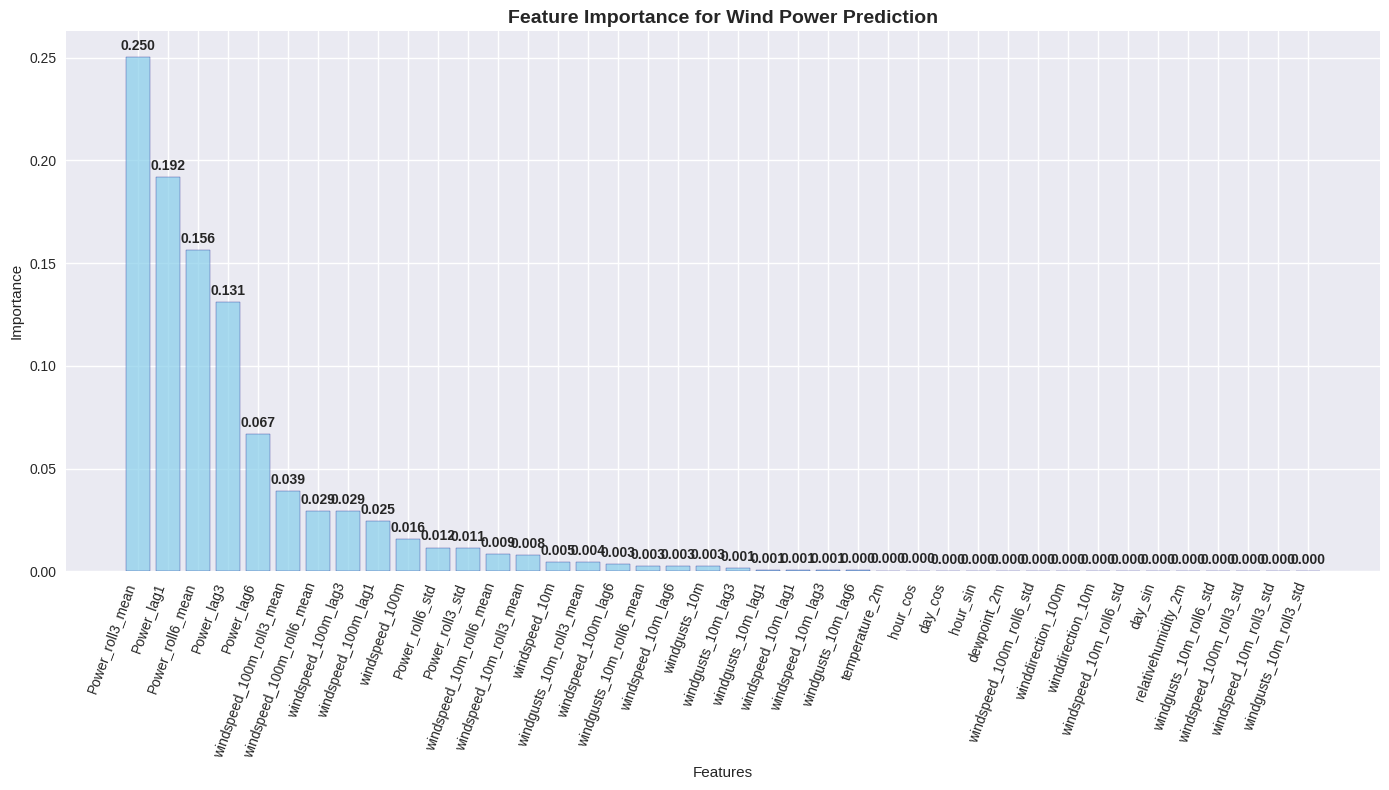

In [42]:
feature_importances = rf.feature_importances_
feature_names = list(X_train.columns)


assert len(feature_names) == len(feature_importances), "Mismatch between features and importances!"

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 8))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue', edgecolor='navy', alpha=0.7)

plt.title('Feature Importance for Wind Power Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=70, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()